In [20]:
import json
import pandas
import numpy as np

!smt export
with open('.smt/records_export.json') as ff:
    data = json.load(ff)
    
with open('record1.json', 'w') as record1:
    for entry in range(len(data)):
        record1.write(json.dumps(data[entry], sort_keys=True, indent=4, separators=(',', ': ')))

df = pandas.DataFrame(data)

In [72]:
df['output_data'][0][-2]['path']

u'1a10x1step20.npz'

In [21]:
df
results = {}
list = {}
fn = np.load('/data/aem1/new1a/surf-research/Andrey/Data/8f1f49c60b96/1a10x1step20.npz')

for x in fn:
        print x
# fn['time']
# del results
# print results

grid
cvar
f
steps
time


In [29]:
import os
import numpy as np

results = {}

#This code will access every step file saved in the Data/[label] directory 
for label in df['label']:
    filepath = os.path.join('/data/aem1/new1a/surf-research/Andrey/Data', label)
    #gets the last step file in the directory (hopefully at equillibrium)
    file = os.listdir('Data/{0}'.format(label))[len(os.listdir('Data/{0}'.format(label)))-2] 
    if file == 'memory_usage.txt':
        break #the memory file should always be the last one saved
    else:
        fn = np.load(os.path.join(filepath, file))
        print file
        size = file[2 : file.find('s')] #the grid size based on filename
        
#         appender = {}
        #for every simulation time, create a dictionary entry to match the cvar values at that time
#         for x in xrange(len(fn['time'])):
#             appender.update({fn['time'][x]:fn['c_var'][x]})
            
        
        
        print fn["time"]

        #add a dictionary entry to associate the size of the grids with the dictionaries of times and their cvar outputs
#         results.update({size:appender})
        data = {'cvar':fn['cvar'], 'freeEn':float(fn['f']), 'step':int(fn['steps']), 'elapsed':float(fn['time'])}
#         print type(data)
#         print type(str(fn['grid']))
        results.update({str(fn['grid']):data})
        
print results
#now we can load this dictionary into a dataframe or interpolate

1a10x1step20.npz
0.572749994933
{'10x1': {'freeEn': 0.7865168606271677, 'cvar': array([ 0.51891702,  0.52141775,  0.5227824 ,  0.52249714,  0.52067124,
        0.51799503,  0.51548632,  0.51410744,  0.51439188,  0.5162315 ,
        0.52216727,  0.52473338,  0.52613019,  0.52583257,  0.52395423,
        0.52120442,  0.51862864,  0.51721569,  0.517513  ,  0.51940729,
        0.52411702,  0.52671377,  0.52812668,  0.52782503,  0.52592393,
        0.52314067,  0.52053328,  0.51910311,  0.51940473,  0.52132308,
        0.52403373,  0.52661595,  0.52802343,  0.52772744,  0.52584098,
        0.52307583,  0.52048314,  0.51905855,  0.51935444,  0.52125794,
        0.52195098,  0.52447891,  0.52586146,  0.52557871,  0.52373882,
        0.52103659,  0.51849941,  0.51710112,  0.51738337,  0.51923872,
        0.51865334,  0.52110659,  0.52245347,  0.52218668,  0.52040856,
        0.51779146,  0.5153307 ,  0.51397003,  0.51423579,  0.51602709,
        0.51539245,  0.51777851,  0.51909224,  0.5188381

In [36]:
results['10x1']['freeEn']

0.7865168606271677

In [30]:
print len(df['output_data'][0])

4


In [31]:
for p in 'N', 'steps', 'sweeps':
    df[p] = df.parameters.map(lambda x: json.loads(x['content'])[p])

In [ ]:
print df['parameters'][0]['content']

In [37]:
df['Free Energy']=results['10x1']['freeEn']
df['elapsed']=results['10x1']['elapsed']

columns.append('Free Energy')
columns.append('elapsed')
df[columns]

,label,N,steps,tags,duration,sweeps,memory,Free Energy,elapsed
0,8f1f49c60b96,10,20,[npzTest],4.042712,2,4648.0,0.786517,0.57275


In [33]:
columns = ['label', 'N', 'steps', 'tags', 'duration', 'sweeps']
print df[columns]

          label   N  steps       tags  duration  sweeps
0  8f1f49c60b96  10     20  [npzTest]  4.042712       2


In [34]:
import numpy as np
import os
num = 0
memoryArray = np.array([])
for num in range(len(df.index)):
    memName = df['output_data'][num][len(df['output_data'][num])-1]['path']
    memlocation = df['datastore'][num]['parameters']['root']
    pool = os.path.join(memlocation, memName)
    memdata = np.loadtxt(pool)
    memoryArray = np.append(memoryArray, memdata)
    print memoryArray
    print ' '
    print num

[ 4648.]
 
0


In [35]:
df['memory']=memoryArray
columns.append('memory')
df[columns]

,label,N,steps,tags,duration,sweeps,memory
0,8f1f49c60b96,10,20,[npzTest],4.042712,2,4648.0


In [38]:
data = {'a' : [1, 2, 3], 'b' : [4, 5, 6]}
pandas.DataFrame(data)

,a,b
0,1,4
1,2,5
2,3,6


In [59]:
data = [{'a' : 1, 'b' : 4}, {'a' : 2, 'b' : 5}, {'a' : 3 ,'b' : 6}]
aa  = pandas.DataFrame(data)

In [60]:
def recalc(row):
    return row.b * 2

In [61]:
print aa

   a  b
0  1  4
1  2  5
2  3  6


In [62]:
aa['c'] = [recalc(row) for index, row in aa.iterrows()]
print aa

   a  b   c
0  1  4   8
1  2  5  10
2  3  6  12


In [55]:
for index, row in aa.iteritems():
    print index, row

a 0    1
1    2
2    3
Name: a, dtype: int64
b 0    4
1    5
2    6
Name: b, dtype: int64
c 0    0
1    0
2    0
Name: c, dtype: int64


In [73]:
times = np.array([0., 1.0, 1.5])
values = times**2


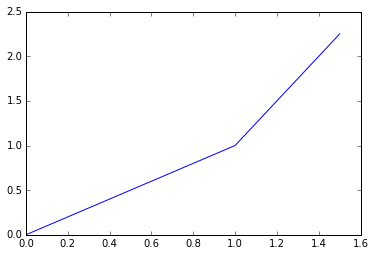

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(times, values)

In [78]:
import numpy as np
np.linspace(0., 100., 1000)

array([   0.        ,    0.1001001 ,    0.2002002 ,    0.3003003 ,
          0.4004004 ,    0.5005005 ,    0.6006006 ,    0.7007007 ,
          0.8008008 ,    0.9009009 ,    1.001001  ,    1.1011011 ,
          1.2012012 ,    1.3013013 ,    1.4014014 ,    1.5015015 ,
          1.6016016 ,    1.7017017 ,    1.8018018 ,    1.9019019 ,
          2.002002  ,    2.1021021 ,    2.2022022 ,    2.3023023 ,
          2.4024024 ,    2.5025025 ,    2.6026026 ,    2.7027027 ,
          2.8028028 ,    2.9029029 ,    3.003003  ,    3.1031031 ,
          3.2032032 ,    3.3033033 ,    3.4034034 ,    3.5035035 ,
          3.6036036 ,    3.7037037 ,    3.8038038 ,    3.9039039 ,
          4.004004  ,    4.1041041 ,    4.2042042 ,    4.3043043 ,
          4.4044044 ,    4.5045045 ,    4.6046046 ,    4.7047047 ,
          4.8048048 ,    4.9049049 ,    5.00500501,    5.10510511,
          5.20520521,    5.30530531,    5.40540541,    5.50550551,
          5.60560561,    5.70570571,    5.80580581,    5.90590

In [83]:
!ls Data/1de38ff12ec7/
import glob
glob.glob('Data/1de38ff12ec7/*.npz')

1a10x1step0.npz  1a10x1step10.npz  1a10x1step20.npz  memory_usage.txt


['Data/1de38ff12ec7/1a10x1step0.npz',
 'Data/1de38ff12ec7/1a10x1step10.npz',
 'Data/1de38ff12ec7/1a10x1step20.npz']